In [1]:
import sunpy.map 
from sunpy.util.scraper import Scraper
from sunpy.time import parse_time
from sunpy.coordinates import get_body_heliographic_stonyhurst
from sunpy.net import Fido, attrs as a
import matplotlib.pyplot as plt 
import numpy as np 
import datetime
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import glob
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from astropy.visualization import PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sunpy.map.sources.source_type import source_stretch
from sunpy.time import TimeRange
from parfive import Downloader
import pylab
import warnings
warnings.filterwarnings("ignore")

## Get the data functionality

In [2]:
def get_euvi_beacon_data(timerange, spacecraft="ahead", earliest=False):
    """
    Function to return url of EUVI beacon data for download.
    
    Parameters
    ----------
    timerange : ~`sunpy..time.TimeRange`
        timerange over which to do the search.
    spacecraft : ~`str`, default = `ahead`
        which STEREO spacecraft to use - either ahead or behind.
        
    Returns
    -------
    fileslist
    
    """
    spacecraft_letter = spacecraft.capitalize()[0]

    # define pattern
    stereo_pattern = ("https://stereo-ssc.nascom.nasa.gov/data/beacon//"
                      "{spacecraft}/secchi/img/euvi/%Y%m%d/%Y%m%d_%H%M%S_n7eu{spacecraft_letter}.fts")

    # instantiate each scraper
    stereo = Scraper(stereo_pattern, spacecraft=spacecraft, spacecraft_letter=spacecraft_letter)

    stereo_files = stereo.filelist(timerange)
    stereo_files.sort()

    if earliest:
        if len(stereo_files)>0:
            return stereo_files[0]
        else:
            return None
        
    
    
    else:
        return stereo_files

In [3]:
def get_closest_aia(time, path="./"):
    time = parse_time(time).datetime
    t1 = time - datetime.timedelta(hours=1)
    t2 = time + datetime.timedelta(hours=1)
    res = Fido.search(a.Time(t1, t2, time),
                      a.Instrument("AIA"),
                      a.Wavelength(193*u.angstrom))
    files = Fido.fetch(res, path=path)
    return files

In [4]:
def get_euvi(files):
    dl = Downloader()
    for f in files:
        dl.enqueue_file(f, path=savedir)
    files = dl.download()
    return files

In [5]:
t1 = parse_time('2013-03-10 12:00') 

t2 = t1 + datetime.timedelta(hours=2)

In [6]:
f1 = get_euvi_beacon_data(TimeRange(t1, t2), earliest=True)
f2 = get_euvi_beacon_data(TimeRange(t1, t2), spacecraft='behind', earliest=True)

In [7]:
f1, f2

('https://stereo-ssc.nascom.nasa.gov/data/beacon//ahead/secchi/img/euvi/20130310/20130310_120530_n7euA.fts',
 'https://stereo-ssc.nascom.nasa.gov/data/beacon//behind/secchi/img/euvi/20130310/20130310_120530_n7euB.fts')

In [8]:
f2

'https://stereo-ssc.nascom.nasa.gov/data/beacon//behind/secchi/img/euvi/20130310/20130310_120530_n7euB.fts'

In [9]:
time_a = parse_time(f1.split("/")[-1][0:15])

In [10]:
savedir = "./test_euvi_data/"

In [11]:
file_a, file_b = get_euvi([f1, f2])

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]
20130310_120530_n7euA.fts:   0%|          | 0.00/547k [00:00<?, ?B/s]

20130310_120530_n7euB.fts:   0%|          | 0.00/547k [00:00<?, ?B/s]
20130310_120530_n7euA.fts:   0%|          | 100/547k [00:00<52:10, 175B/s]

20130310_120530_n7euB.fts:   0%|          | 100/547k [00:00<52:13, 175B/s]
20130310_120530_n7euA.fts:   9%|▉         | 48.5k/547k [00:00<00:05, 96.4kB/s]

20130310_120530_n7euB.fts:   9%|▉         | 48.5k/547k [00:00<00:05, 96.5kB/s]
20130310_120530_n7euA.fts:  29%|██▉       | 161k/547k [00:00<00:01, 315kB/s]  

20130310_120530_n7euB.fts:  25%|██▍       | 136k/547k [00:00<00:01, 261kB/s]  
20130310_120530_n7euA.fts:  69%|██████▉   | 378k/547k [00:00<00:00, 733kB/s]

20130310_120530_n7euB.fts:  56%|█████▌    | 305k/547k [00:00<00:00, 588kB/s]
Files Downloaded:  50%|█████     | 1/2 [00:01<00:01,  1.65s/file]0, 732kB/s]

Files Downloaded: 100%|██████████| 2/2 [00:01<00:00,  1.17file/s]0, 768kB/s]


In [12]:
res = get_closest_aia(time_a, path=savedir)


                                                                            

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]                   
aia_lev1_193a_2013_03_10t12_05_30_84z_image_lev1.fits:   0%|          | 0.00/12.6M [00:00<?, ?B/s]
aia_lev1_193a_2013_03_10t12_05_30_84z_image_lev1.fits:   0%|          | 100/12.6M [00:05<176:27:36, 19.8B/s]
aia_lev1_193a_2013_03_10t12_05_30_84z_image_lev1.fits:   0%|          | 13.9k/12.6M [00:05<56:25, 3.71kB/s] 
aia_lev1_193a_2013_03_10t12_05_30_84z_image_lev1.fits:   0%|          | 35.0k/12.6M [00:05<19:11, 10.9kB/s]
aia_lev1_193a_2013_03_10t12_05_30_84z_image_lev1.fits:   1%|          | 67.4k/12.6M [00:05<08:26, 24.7kB/s]
aia_lev1_193a_2013_03_10t12_05_30_84z_image_lev1.fits:   1%|          | 112k/12.6M [00:05<04:20, 47.8kB/s] 
aia_lev1_193a_2013_03_10t12_05_30_84z_image_lev1.fits:   1%|▏         | 160k/12.6M [00:06<02:46, 74.4kB/s]
aia_lev1_193a_2013_03_10t12_05_30_84z_image_lev1.fits:   2%|▏         | 211k/12.6M [00:06<01:58,

## Analyse the data and make outmap

In [13]:
file_a = glob.glob("./test_euvi_data/*{:s}*n7euA*".format(t1.strftime("%Y%m%d")))
file_b = glob.glob("./test_euvi_data/*{:s}*n7euB*".format(t1.strftime("%Y%m%d")))
file_aia = glob.glob("./test_euvi_data/*{:s}*lev1.fits".format(t1.strftime("%Y_%m_%d")))

In [14]:
ls *.fts

20120926_025530_17euA.fts  20120926_091530_n7euB.fts
20120926_025530_n7euA.fts  20131007_040530_n7euA.fts
20120926_091530_17euB.fts


In [15]:
# ff = get_closest_aia("2012-09-27 03:00")

In [30]:
file_aia_test = "aia_lev1_193a_2012_09_27t02_59_54_84z_image_lev1.fits"
file_a_unprep = "20120926_025530_n7euA.fts"
file_a = "20120926_025530_17euA.fts"

file_b_unprep = "20120926_091530_n7euB.fts"
file_b = "20120926_091530_17euB.fts"


In [31]:
map_a = sunpy.map.Map(file_a)
map_b = sunpy.map.Map(file_b)
map_aia = sunpy.map.Map(file_aia_test)

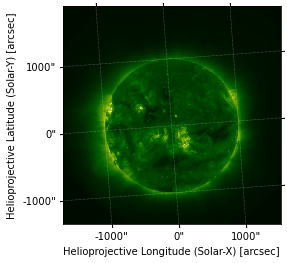

In [32]:
map_a.plot()

In [33]:
import sunpy
sunpy.__file__

'/Users/laurahayes/miniconda3/lib/python3.7/site-packages/sunpy/__init__.py'

In [34]:
# map_a = map_a.rotate()
# map_b = map_b.rotate()

In [35]:
# map_a = sunpy.map.Map(map_a.data/map_a.exposure_time.to_value(u.s), map_a.meta)
# map_b = sunpy.map.Map(map_b.data/map_b.exposure_time.to_value(u.s), map_b.meta)
map_aia = sunpy.map.Map((map_aia.data/map_aia.exposure_time.to_value(u.s))/1.9, map_aia.meta)

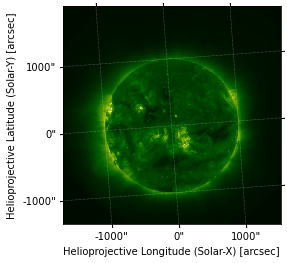

In [36]:
map_a.plot()

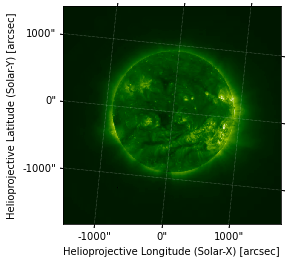

In [37]:
map_b.plot()


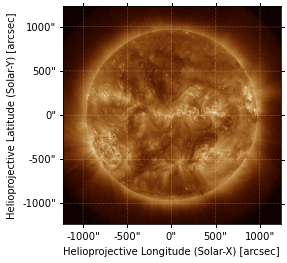

In [38]:
map_aia.plot()

In [39]:
def get_carr(map1, map2, map3):


    maps = [map1, map2, map3]
    maps = [m.resample((1024, 1024)*u.pix) for m in maps]

    shape_out = (180, 360)  # This is set deliberately low to reduce memory consumption

    header = sunpy.map.make_fitswcs_header(shape_out,
                                           SkyCoord(0, 0, unit=u.deg,
                                                    frame="heliographic_stonyhurst",
                                                    obstime=maps[0].date),
                                           scale=[180 / shape_out[0],
                                                  360 / shape_out[1]] * u.deg / u.pix,
                                           wavelength=int(maps[0].meta['wavelnth']) * u.AA,
                                           projection_code="CAR")
    out_wcs = WCS(header)

    coordinates = tuple(map(sunpy.map.all_coordinates_from_map, maps))
    weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]

    weights = [(w / np.nanmax(w)) ** 3 for w in weights]
    for w in weights:
        w[np.isnan(w)] = 0

    array, _ = reproject_and_coadd(maps, out_wcs, shape_out,
                                   input_weights=weights,
                                   reproject_function=reproject_interp,
                                   match_background=True,
                                   background_reference=0)


    outmap = sunpy.map.Map((array, header))

    # plotting 
    plot_settings = {"cmap": "sohoeit195", 
                 "norm": ImageNormalize(stretch=source_stretch(outmap.meta, PowerStretch(0.25)), clip=False)}

    outmap.plot_settings = plot_settings
    outmap.nickname = 'AIA + EUVI/A + EUVI/B'

    cmap = outmap.cmap
    cmap.set_bad(color="k")

    return outmap

In [40]:
outmap = get_carr(map_a, map_b, map_aia)

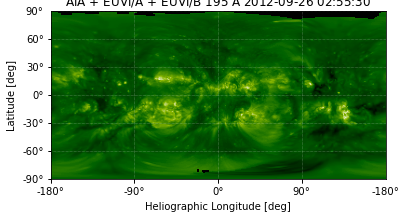

In [41]:
outmap.plot()

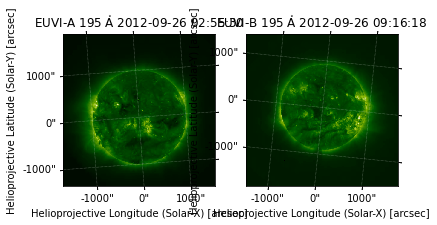

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection=map_a)
map_a.plot(axes=ax1)
ax2 = fig.add_subplot(1,2,2, projection=map_b)
map_b.plot(axes=ax2)

In [47]:
def make_submap(mapy):
    bl = SkyCoord(-1200*u.arcsec, -1200*u.arcsec, frame=mapy.coordinate_frame)
    tr = SkyCoord(1200*u.arcsec, 1200*u.arcsec, frame=mapy.coordinate_frame)
    return mapy.submap(bl, top_right=tr)

In [122]:
map_a  = map_a.rotate()
map_b = map_b.rotate()

In [123]:
map_aa = make_submap(map_a)
map_bb = make_submap(map_b)
map_aia = make_submap(map_aia)

In [124]:
print(map_aa.date.datetime)
print(map_bb.date.datetime)
print(map_aia.date.datetime)

2012-09-26 02:55:30.008000
2012-09-26 09:16:18.561000
2012-09-27 02:59:54.840000


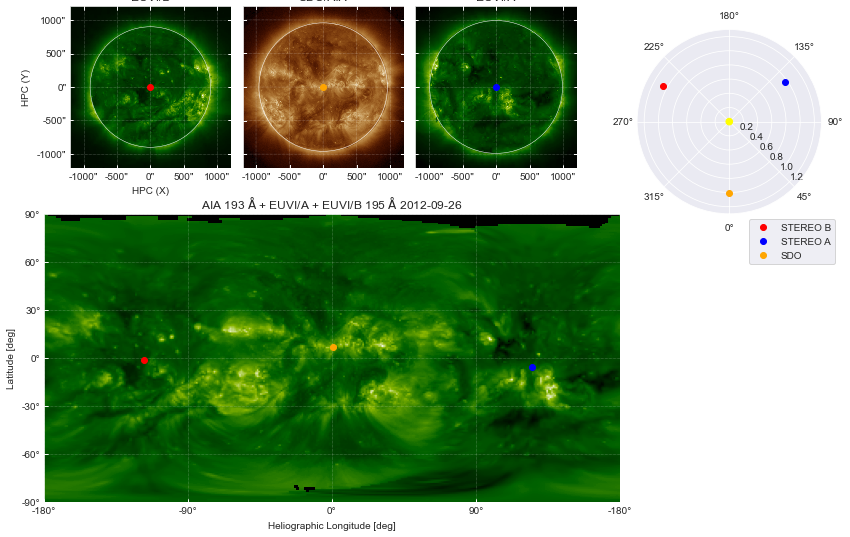

In [133]:
fig = plt.figure(figsize=(12, 8))

#left, bottom, width, height
w_map = 0.28
map_bottom = 0.68

# map stereo_a
ax1 = pylab.axes([0.05, map_bottom, w_map, w_map], projection=map_bb)
# map aia
ax2 = pylab.axes([0.25, map_bottom, w_map, w_map], projection=map_aia)
# map stereo_b
ax3 = pylab.axes([0.45 , map_bottom, w_map, w_map], projection=map_aa)
# map car map
ax4 = pylab.axes([0.05, 0.1, 0.7, 0.5], projection=outmap)
# polar plot
ax5 = pylab.axes([0.7, 0.6, 0.32, 0.32], projection='polar')


# plot STEREO-B
map_bb.plot(axes=ax1)
map_bb.draw_limb(lw=0.5)
ax1.plot_coord(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_bb.coordinate_frame), color="r", marker="o")
ax1.set_ylabel("HPC (Y)")
ax1.set_xlabel("HPC (X)")
ax1.set_title("EUVI/B")

# plot AIA 
map_aia.plot(axes=ax2)
map_aia.draw_limb(lw=0.5)
ax2.plot_coord(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_aia.coordinate_frame), color="orange", marker="o")
ax2.set_ylabel(" ")
ax2.set_xlabel(" ")
ax2.tick_params(axis="y", labelleft=False)
ax2.set_title("SDO/AIA")

# plot STEREO-A
map_aa.plot(axes=ax3)
map_aa.draw_limb(lw=0.5)
ax3.plot_coord(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_aa.coordinate_frame), color="b", marker="o")

ax3.set_ylabel(" ")
ax3.set_xlabel(" ")
ax3.tick_params(axis="y", labelleft=False)
ax3.set_title("EUVI/A")


# plot the HGS map
outmap.plot(axes=ax4,
            title="AIA 193 $\mathrm{\AA}$ + EUVI/A + EUVI/B 195 $\mathrm{\AA}$ " +outmap.date.datetime.strftime("%Y-%m-%d"))
ax4.plot_coord(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_bb.coordinate_frame), color="r", marker="o")
ax4.plot_coord(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_aia.coordinate_frame), color="orange", marker="o")
ax4.plot_coord(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_aa.coordinate_frame), color="b", marker="o")


for axes in (ax1, ax2, ax3, ax4):
    axes.tick_params(which="both", direction="in", color="w")

# plot polar plot of positions
r_unit = u.AU
circle = plt.Circle((0.0, 0.0), (10*u.Rsun).to_value(r_unit),
                    transform=ax5.transProjectionAffine + ax5.transAxes, color="yellow",
                    alpha=1, label="Sun")

ax5.add_artist(circle)

ax5.plot(map_bb.observer_coordinate.lon.to('rad'), 
         map_bb.observer_coordinate.radius.to(r_unit), 'o', label=map_bb.observatory, color="r")
ax5.plot(map_aa.observer_coordinate.lon.to('rad'), 
         map_aa.observer_coordinate.radius.to(r_unit), 'o', label=map_aa.observatory, color="b")
ax5.plot(map_aia.observer_coordinate.lon.to('rad'), 
         map_aia.observer_coordinate.radius.to(r_unit), 'o', label=map_aia.observatory, color="orange")


ax5.set_theta_zero_location("S")
ax5.set_rlim(0, 1.3)
ax5.set_rlabel_position(45.5)
ax5.legend(bbox_to_anchor=(1.1, -0.3), loc="lower right")


plt.savefig("testy.png", facecolor='w', transparent=False, dpi=200)

In [51]:
def plot_positions():
    maps = [map_aa, map_aia, map_bb]

    earth = get_body_heliographic_stonyhurst('earth', maps[0].date)

    plt.figure(figsize=(8, 8))
    r_unit = u.AU

    ax = plt.subplot(projection='polar')
    circle = plt.Circle((0.0, 0.0), (10*u.Rsun).to_value(r_unit),
                        transform=ax.transProjectionAffine + ax.transAxes, color="yellow",
                        alpha=1, label="Sun")
    ax.add_artist(circle)
    #ax.text(earth.lon.to_value("rad")+0.05, earth.radius.to_value(r_unit), "Earth")

    for this_satellite, this_coord in [(m.observatory, m.observer_coordinate) for m in maps]:
        plt.polar(this_coord.lon.to('rad'), this_coord.radius.to(r_unit), 'o', label=this_satellite)

    ax.set_theta_zero_location("S")
    ax.set_rlim(0, 1.3)
    ax.set_rlabel_position(45.5)
    plt.legend()
    plt.show()

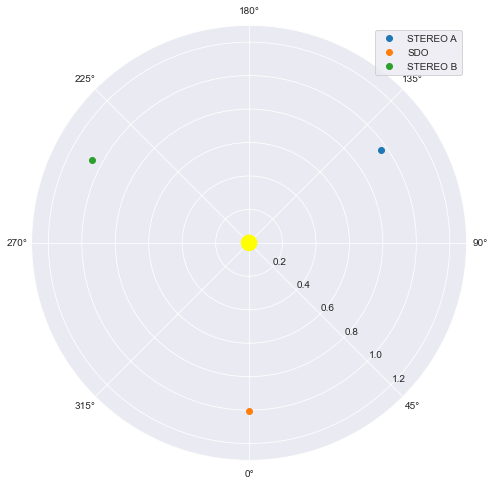

In [55]:
import seaborn as sns
sns.set_style("dark")
plot_positions()

In [ ]:
cart_aa = map_aa.observer_coordinate.cartesian
cart_bb = map_bb.observer_coordinate.cartesian
cart_aia = map_aia.observer_coordinate.cartesian
earth_cart = earth.cartesian

In [ ]:
sun = get_body_heliographic_stonyhurst("sun", maps[0].date)
sun_cart = sun.cartesian

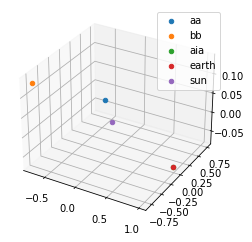

In [238]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(cart_aa.x.to(u.AU), cart_aa.y.to(u.AU), cart_aa.z.to(u.AU), label="aa")
ax.scatter(cart_bb.x.to(u.AU), cart_bb.y.to(u.AU), cart_bb.z.to(u.AU), label="bb")
ax.scatter(cart_aia.x.to(u.AU), cart_aia.y.to(u.AU), cart_aia.z.to(u.AU), label="aia")
ax.scatter(earth_cart.x.to(u.AU), earth_cart.y.to(u.AU), earth_cart.z.to(u.AU), label="earth")
ax.scatter(sun_cart.x.to(u.AU), sun_cart.y.to(u.AU), sun_cart.z.to(u.AU), label="sun")
ax.legend()

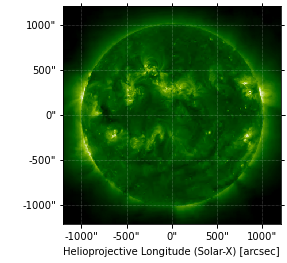

In [144]:
map_aa.plot()
ax = plt.gca()
ax.set_ylabel(" ")

In [2]:
def get_secchi_beacon_data(timerange, instr, spacecraft="ahead"):
    """
    Function to return url of SECCHI beacon data for download.
    
    Parameters
    ----------
    timerange : ~`sunpy..time.TimeRange`
        timerange over which to do the search.
    instr: `str`
        name of instrument wanted - "euvi", 
    spacecraft : ~`str`, default = `ahead`
        which STEREO spacecraft to use - either ahead or behind.
        
    Returns
    -------
    fileslist
    
    """
    dicty = {"euvi": "n7eu",
             "hi_1": "d7c2",
             "hi_2": "s7h1",
             "cor2": "d7c2"}
    
    spacecraft_letter = spacecraft.capitalize()[0]

    # define pattern
    stereo_pattern = ("https://stereo-ssc.nascom.nasa.gov/data/beacon//"
                      "{spacecraft}/secchi/img/euvi/%Y%m%d/%Y%m%d_%H%M%S_n7eu{spacecraft_letter}.fts")

    # instantiate each scraper
    stereo = Scraper(stereo_pattern, spacecraft=spacecraft, spacecraft_letter=spacecraft_letter)

    stereo_files = stereo.filelist(timerange)
    stereo_files.sort()


    return stereo_files

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


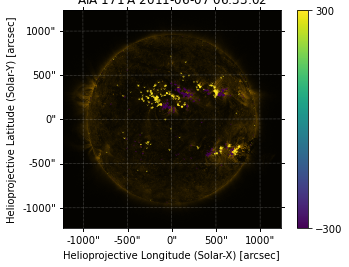

In [ ]:
""